###   |-------------------------------------------------------------------------------------------------|
# | Automatic projections with Hubble and JWST |
###   |-------------------------------------------------------------------------------------------------|

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import glob
from PIL import Image
from scipy import ndimage
import copy
import math
from math import atan2, degrees
import astropy.time
import dateutil.parser

#### Defining of directory and variables

We define our path with file, specify the filter in filt. By default WinJupos saves the files with the last word "MAP", so we will use it as a way to find all the files we are interested in. You can define the kind of the file in kind. Specify also the hemisphere with NORTH or SOUTH in case you are working with a polar or stereographic projection. For Jupiter, the Radius in pixel is exactly 1800 pixels, you can change it in case it does not fit.

The kernel dim defines the dimension of the gaussian filter, for 0.889 microns the best ones is 10.

##### Winjupos input parameters

Map width = 3600

System = 3

Automatic brightness and colour correction of image segments = True

Page layout = {Scales=True, Size=10, Scale captions=True, captions=True}

Latitude = Planetographic


In [2]:
k = input('Which projection do you want? STEREOGRAPHIC = 1, POLAR = 2, EQUATORIAL = 3 --> ')
print(' ')

if k == '1' or k == '2':
    pole = input('Which pole do you want? NORTH or SOUTH (Capital letters!) --> ')

Which projection do you want? STEREOGRAPHIC = 1, POLAR = 2, EQUATORIAL = 3 --> EQUATORIAL
 


In [3]:
file = 'C:/Users/povalle/Desktop/results/winds/Jupiter2021/DRZ/' #where your filter folders are
filt = 'FQ889Nx/'   #the name of the folder for the ilter you are analyzing and where your specific images are
kind = '.tif'       # kind of image file
key = 'MAP' + kind  # keyword for the name winjupos outputs.
channel = 0
kernel_dim = 25

if k == '1':
    projection = 'STEREO'
elif k == '2':
    projection = 'POLAR'
elif k == '3':
    projection = 'EQUATORIAL'

R = 1800
outnamepolar = 'polar_map.tif'
outnamestereo = 'stereographic_map.tif'
outnameequatorial = 'equatorial_map.tif'

# =================================================================

images=[]
images_path=[]
d = {}
imarr = {}
mask2 = {}
den = 0
datex = {}
timex = {}

#### Looking for all science images

We look for in the directory specified for all the images needed (ended in MAP.tif in this case). The path is saved in the variable images_path.

It outputs the number of images that will be used.

In [4]:
path = file + filt
directory = os.listdir(path)
for i in range(len(directory)):
    if key in directory[i]:
        images.append(directory[i])
for i in range(len(images)):
    images_path.append(file+filt+images[i])
print('there are ' + str(len(images_path)) + ' images for the merging process.')
print("")
print("--------------------------------------------")

there are 13 images for the merging process.

--------------------------------------------


#### Open images

We open all the images and store them in a variable d.

In [4]:
for x in range(len(images)): 
    d['{0}'.format(x)] = Image.open(images_path[x])

#### Calculate the Central Meridian Longitude

For every date in the Winjupos format, we calculate the CML individually. This information is useful for the Lambert correction. The way it is calculated is simple but not very precise. Nevertheless lat and lon can be used to do lambert corrections, so it is precise enough.

In [5]:
CM = np.zeros(len(images))
date = copy.copy(images)

for i in range(len(images)):
    
    date[i] = date[i].replace('-', '.')
    timex[i] = date[i][11:13] + ':' + date[i][13:15] + ':00'
    date[i] = date[i][0:10]
    date[i] = date[i] + ' ' + timex[i]
    dt = dateutil.parser.parse(date[i])
    time = astropy.time.Time(dt)
    jd = time.jd
    jup_mean = (jd - 2455636.938) * 360. / 4332.89709
    eqn_center = 5.55 * np.sin( jup_mean*np.pi/180 )
    angle = (jd - 2451870.628) * 360. / 398.884 - eqn_center
    correction = 11 * np.sin(angle*np.pi/180) + 5*np.cos(angle*np.pi/180) - 1.25*np.cos(jup_mean*np. pi/180) - eqn_center  
    CM[i] = 138.41 + 870.4535567 * jd + correction 
    CMx = CM[i]/360
    k = math.modf(CMx)[1]
    CM[i] = CM[i]-(360*k)
    print('Obtained Central Meridian (S III) of image ' + str(i) + ' ---> ' + str(CM[i]))
print('')
print('ADVICE: Compare your CM with the CM from Winjupos. The expected deviation is of 1-2 degrees.')

Obtained Central Meridian (S III) of image 0 ---> 275.3476324081421
Obtained Central Meridian (S III) of image 1 ---> 333.38716769218445
Obtained Central Meridian (S III) of image 2 ---> 30.822115898132324
Obtained Central Meridian (S III) of image 3 ---> 88.25705623626709
Obtained Central Meridian (S III) of image 4 ---> 146.29656624794006
Obtained Central Meridian (S III) of image 5 ---> 203.7314898967743
Obtained Central Meridian (S III) of image 6 ---> 261.16640543937683
Obtained Central Meridian (S III) of image 7 ---> 319.2058906555176
Obtained Central Meridian (S III) of image 8 ---> 16.640789270401
Obtained Central Meridian (S III) of image 9 ---> 74.07568025588989
Obtained Central Meridian (S III) of image 10 ---> 132.11514019966125
Obtained Central Meridian (S III) of image 11 ---> 191.96832466125488
Obtained Central Meridian (S III) of image 12 ---> 251.21692276000977

ADVICE: Compare your CM with the CM from Winjupos. The expected deviation is of 1-2 degrees.


#### First mask

We create a mask to disminish the effect of the labels of Winjupos. This step can be ommited.

In [6]:
imarr['{0}'.format(0)] = np.asarray(d['{0}'.format(0)])
count = imarr['{0}'.format(0)].max()
imarr['{0}'.format(0)] = abs(imarr['{0}'.format(0)] - count)
mask = imarr['0'][:,:,0]-imarr['0'][:,:,2]
mask = abs(mask - count)
mask = mask - 1
mask = count*(mask/mask.max())

xpixmean = int(imarr['{0}'.format(0)].shape[0]/2)
ypixmean = int(imarr['{0}'.format(0)].shape[1]/2)

origin = [xpixmean-35,ypixmean+5]  # Centered manually because of the labels of 

#### Latitude and longitude navigation

Here the code creates a grid for the latitude and longitude in polar (we can choose stereographic or purely polar) projection. We assume a perfectly round body since these values are going to be used to make lambert corrections, so there is no need of extra precission.

These lat and lon are based on the outputs of Winjupos, and as can be seen the origin variable has been manually changed in order to find exactly the center of the planet in the image.

The same case for the equatorial projections, where we develop a linear fit for the lat and lon as a function of the pixel position, and we define the grid where we will have this information.

Remember using the winjupos input parameters for having the most precise results.

We also calculate the local longitude, e.g. the longitudinal map where the Central meridian longitude equals 0. This can be useful for your lambert corrections.

Finally we plot both latitude and longitude just to check.

Calculating latitude and longitude grids ...
Creating local maps

Created Local meridian longitude map number 0
Created Local meridian longitude map number 1
Created Local meridian longitude map number 2
Created Local meridian longitude map number 3
Created Local meridian longitude map number 4
Created Local meridian longitude map number 5
Created Local meridian longitude map number 6
Created Local meridian longitude map number 7
Created Local meridian longitude map number 8
Created Local meridian longitude map number 9
Created Local meridian longitude map number 10
Created Local meridian longitude map number 11
Created Local meridian longitude map number 12

Navigation Finished

-------------------------------------------------

Plotting


<Figure size 2000x1400 with 0 Axes>

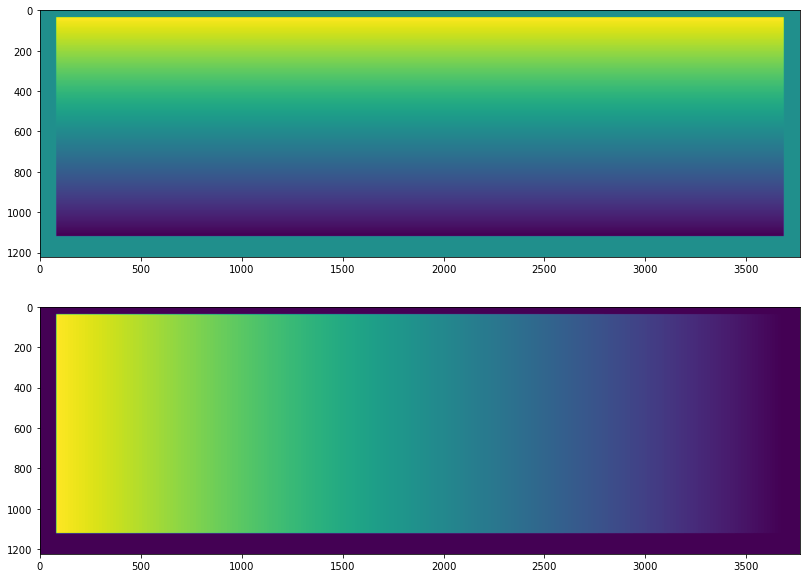

In [7]:
print("Calculating latitude and longitude grids ...")

latarr = np.zeros((xpixmean*2,ypixmean*2))
lonarr = np.zeros((xpixmean*2,ypixmean*2))
locallonarr = np.zeros((xpixmean*2,ypixmean*2, len(images)))

if projection == 'POLAR' or projection == 'STEREO':
    for i in range(xpixmean*2):
        for ii in range(ypixmean*2):
            target = [i,ii]
            dx2 = (origin[0]-target[0])**2    
            dy2 = (origin[1]-target[1])**2         
            r = math.sqrt(dx2 + dy2)
            if pole == 'NORTH':
                angle = atan2(origin[0] - target[0], origin[1] - target[1])
            elif pole == 'SOUTH':
                angle = atan2(origin[1] - target[1], origin[0] - target[0]) - np.pi/2
            angle = degrees(angle)
            if r/R > 1:
                latarr[i][ii] = float('NaN')
                lonarr[i][ii] = float('NaN')
            else:
                if projection == 'STEREO':
                    latarr[i][ii] = (1-(r/R))*90
                elif projection == 'POLAR':
                    latarr[i][ii] = abs(90*np.cos((r/R)*(np.pi/2)))
                if angle<0:
                    angle = angle + 360
                lonarr[i][ii] = angle

    if pole == 'SOUTH':
        latarr = -latarr

if projection == 'EQUATORIAL':
    for i in range(xpixmean*2):
        if 40 <= i <=1120 : # Numbers to fit the format from winjupos
            for ii in range(ypixmean*2): # Numbers to fit the format from winjupos
                if 80 <= ii <= 3683:
                    latarr[i,ii] = -i/6 + 96.6667
                    lonarr[i,ii] = -ii/10 + 368

print("Creating local maps")
print("")
for i in range(len(images)):
    locallonarr[:,:,i] = lonarr-CM[i]

for z in range(len(images)):
    for i in range(xpixmean*2):
        for ii in range(ypixmean*2):
            if locallonarr[i,ii,z]<0:
                locallonarr[i,ii,z] = locallonarr[i,ii,z]+360    
    print('Created Local meridian longitude map number ' + str(z))

print("")
print("Navigation Finished")
print("")
print("-------------------------------------------------")
print("")
print("Plotting")

if projection == 'POLAR' or projection == 'STEREO':

    figure(figsize=(10, 7), dpi=200)
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7))

    if pole == 'NORTH':
        im1 = ax1.imshow(latarr, vmax=90)
        im1.contours = ax1.contour(latarr,[0,10,20,30,40,50,60,70,80,87,89.9], colors="black", linewidths = 0.5)
        ax1.clabel(im1.contours, inline=1, fontsize=12)
    if pole == 'SOUTH':
        im1 = ax1.imshow(latarr, vmax=0)
        im1.contours = ax1.contour(latarr,[-89.9,-87,-80,-70,-60,-50,-40,-30,-20,-10,-0], colors="black", linewidths = 0.5)
        ax1.clabel(im1.contours, inline=1, fontsize=12)

    im2 = ax2.imshow(lonarr, cmap = "viridis", vmax=360)
    im2.contours = ax2.contour(lonarr,[0,45,90,135,180,225,270,315], colors="black", linewidths = 0.5)
    ax2.clabel(im2.contours, inline=1, fontsize=12)

elif projection == 'EQUATORIAL':
    
    figure(figsize=(10, 7), dpi=200)
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,10))
    im1 = ax1.imshow(latarr)
    im2 = ax2.imshow(lonarr)

#### Image processing

We transform the images in arrays, and apply them two masks in order to better the results. We give a weight to the pixels as a function of the number of images that are overposed in order to get a better result.

In both cases the best result is obtained when we merge two images, one with a low pass filter and other without it. For the polar regions the best fit is without this filter, but for low latitude regions the best results need the use of this filter.

Array transformation 0 -->  2021-09-04-0100-HST-FQ889N_MAP.tif
Array transformation 1 -->  2021-09-04-0236-HST-FQ889N_MAP.tif
Array transformation 2 -->  2021-09-04-0411-HST-FQ889N_MAP.tif
Array transformation 3 -->  2021-09-04-0546-HST-FQ889N_MAP.tif
Array transformation 4 -->  2021-09-04-0722-HST-FQ889N_MAP.tif
Array transformation 5 -->  2021-09-04-0857-HST-FQ889N_MAP.tif
Array transformation 6 -->  2021-09-04-1032-HST-FQ889N_MAP.tif
Array transformation 7 -->  2021-09-04-1208-HST-FQ889N_MAP.tif
Array transformation 8 -->  2021-09-04-1343-HST-FQ889N_MAP.tif
Array transformation 9 -->  2021-09-04-1518-HST-FQ889N_MAP.tif
Array transformation 10 -->  2021-09-04-1654-HST-FQ889N_MAP.tif
Array transformation 11 -->  2021-09-04-1833-HST-FQ889N_MAP.tif
Array transformation 12 -->  2021-09-04-2011-HST-FQ889N_MAP.tif

Creating composition ...
10% Completed.
20% Completed.
30% Completed.
40% Completed.
50% Completed.
60% Completed.
70% Completed.
80% Completed.
90% Completed.
100% Completed.



<Figure size 9000x6000 with 0 Axes>

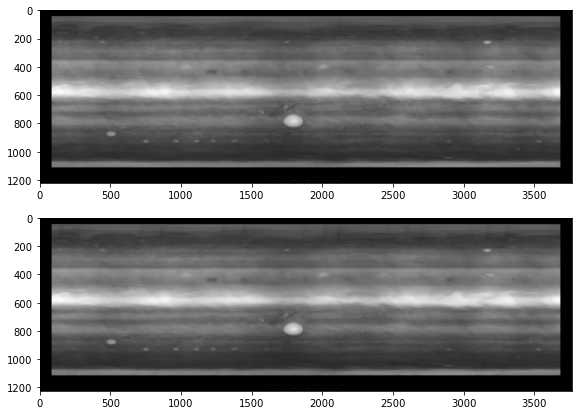

In [15]:
kernel = np.ones((kernel_dim,kernel_dim))
kernel = kernel/(kernel.shape[0]*kernel.shape[1])
den1 = 0
den2 = 0

for x in range(len(images)): 
    image = np.asarray(d['{0}'.format(x)])[:,:,channel]
    image = image.astype(np.uint32)
    image[ image>count-1 ] = 0  # Remove hot pixels
    image = image - mask
    image[image <= 0 ] = 0 # Remove negative values for masking
    mask2 = copy.copy(image)
    mask2[ mask2<=20] = 0 
    mask3 = ndimage.gaussian_filter(mask2, sigma=kernel_dim)
    if x == 0:
        num1 = image*mask2
        num2 = image*mask3
    else:
        num1 = num1 + image*mask2
        num2 = num2 + image*mask3
        
    den1 = den1 + mask2
    den2 = den2 + mask3
    print('Array transformation '+ str(x) + ' --> ', str(images[x]))

np.seterr(invalid='ignore')
im1 = np.nan_to_num(num1/den1)
im2 = np.nan_to_num(num2/den2)

composition = np.zeros((xpixmean*2,ypixmean*2))

print("")
print("Creating composition ...")

if projection == 'POLAR' or projection == 'STEREO':
    for i in range(xpixmean*2):
        if i == 360: print("10% Completed.")
        elif i == 2*360: print("20% Completed.")    
        elif i == 3*360: print("30% Completed.") 
        elif i == 4*360: print("40% Completed.") 
        elif i == 5*360: print("50% Completed.") 
        elif i == 6*360: print("60% Completed.") 
        elif i == 7*360: print("70% Completed.") 
        elif i == 8*360: print("80% Completed.") 
        elif i == 9*360: print("90% Completed.") 
        elif i == 10*360: print("100% Completed.") 
        for ii in range(ypixmean*2):
            target = [i,ii]
            dx2 = (origin[0]-target[0])**2    
            dy2 = (origin[1]-target[1])**2         
            r = math.sqrt(dx2 + dy2)
            if r/R<0.5:
                composition[i,ii] = im1[i,ii]
            else:
                composition[i,ii] = im2[i,ii]
                
elif projection == 'EQUATORIAL':
    for i in range(xpixmean*2):
        if i == 110: print("10% Completed.")
        elif i == 2*110: print("20% Completed.")    
        elif i == 3*110: print("30% Completed.") 
        elif i == 4*110: print("40% Completed.") 
        elif i == 5*110: print("50% Completed.") 
        elif i == 6*110: print("60% Completed.") 
        elif i == 7*110: print("70% Completed.") 
        elif i == 8*110: print("80% Completed.") 
        elif i == 9*110: print("90% Completed.") 
        elif i == 10*110: print("100% Completed.") 
        for ii in range(ypixmean*2):
            if latarr[i,ii] <= 60:
                composition[i,ii] = im2[i,ii]
            else:
                composition[i,ii] = im1[i,ii]

print("")
print("Plotting results ...")

figure(figsize=(15, 10), dpi=600)
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,7))

im1 = ax1.imshow(im1,cmap="gray")
im2 = ax2.imshow(im2,cmap="gray")

#### The result can be seen here.

In [14]:
figure(figsize=(15, 5), dpi=1000)
plt.imshow(composition,cmap="gray")

#### The result can be saved here. Choose the format that you prefer

In [12]:
if projection == 'POLAR':
    composition = Image.fromarray(composition)
    composition.save(file + filt + outnamepolar)

if projection == 'EQUATORIAL':
    composition = Image.fromarray(composition)
    composition.save(file + filt + outnameequatorial)

if projection == 'STEREO':
    composition = Image.fromarray(composition)
    composition.save(file + filt + outnamestereo)

With the navigated images the lambert correction must be easy, and will be added in the folowing updates.

Last mod. 27/07/2022. Pablo Rodriguez Ovalle and Ricardo Hueso